In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import pprint
import re
from sentence_transformers import util
from transformers import BertModel, BertTokenizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import torch
from tqdm import tqdm

In [3]:
track_data = pd.read_csv('misc/processed_music_info.csv')
track_lyrics = pd.read_csv('misc/track_lyrics.csv')

In [4]:
saved_embeddings_path = 'misc/lyrics_embeddings.npy'
saved_embeddings_3d_path = 'misc/lyrics_embeddings_3d.npy'

model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dim_model = PCA(n_components=50, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23584 entries, 0 to 23583
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          23584 non-null  object 
 1   name              23584 non-null  object 
 2   artist            23584 non-null  object 
 3   spotify_id        23584 non-null  object 
 4   tags              23083 non-null  object 
 5   year              23584 non-null  int64  
 6   duration_ms       23584 non-null  int64  
 7   danceability      23584 non-null  float64
 8   energy            23584 non-null  float64
 9   key               23584 non-null  int64  
 10  loudness          23584 non-null  float64
 11  mode              23584 non-null  int64  
 12  speechiness       23584 non-null  float64
 13  acousticness      23584 non-null  float64
 14  instrumentalness  23584 non-null  float64
 15  liveness          23584 non-null  float64
 16  valence           23584 non-null  float6

In [6]:
track_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23584 entries, 0 to 23583
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  23584 non-null  object
 1   lyrics    23584 non-null  object
dtypes: object(2)
memory usage: 368.6+ KB


In [7]:
track_ids_exist = track_data['track_id'].isin(track_lyrics['track_id'])
all_track_ids_exist = track_ids_exist.all()
if not all_track_ids_exist:
	print('Some track ids do not exist in track_lyrics')
	print(track_data[~track_ids_exist])

In [8]:
def clean_text(text):
    if text == "This song is instrumental." or not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)
    text = text.replace("|||", "")
    return text.strip()

track_lyrics['lyrics'] = track_lyrics['lyrics'].apply(clean_text)

In [9]:
cls_token = '[CLS]'
sep_token = '[SEP]'
for idx, row in track_lyrics.iterrows():
	if idx in track_data.index:
		track_data_row = track_data.loc[idx]
		title = clean_text(track_data_row['name'])
		artist = clean_text(track_data_row['artist'])
		genres = clean_text(track_data_row['tags'])
		lyrics = row['lyrics']
		input_string = f"{cls_token} {title} {sep_token} {artist} {sep_token} {genres} {sep_token} {lyrics} {sep_token}"
		track_lyrics.at[idx, 'lyrics'] = input_string

In [10]:
type(model)

transformers.models.bert.modeling_bert.BertModel

In [11]:
def get_tokens(text):
    encoded_input = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt').input_ids.to(device)
    return encoded_input

def get_bert_embeddings(encoded_input):
	with torch.no_grad():
		embeddings = model(encoded_input)
		cls_embeddings = embeddings.last_hidden_state[:, 0, :].squeeze().cpu()
	return cls_embeddings.numpy()

In [12]:
#track_lyrics = track_lyrics.sample(n=100, random_state=42)

In [13]:

if os.path.exists(saved_embeddings_path):
	lyrics_embeddings_array = np.load(saved_embeddings_path)
else:
	lyrics_embeddings = {}
	with tqdm(total=len(track_lyrics)) as pbar:
		for idx, row in track_lyrics.iterrows():
			encoded_input = get_tokens(row['lyrics'])
			lyrics_embedding = get_bert_embeddings(encoded_input)
			lyrics_embeddings[row['track_id']] = lyrics_embedding
			pbar.update(1)
	lyrics_embeddings_array = np.array(list(lyrics_embeddings.values()))
	lyrics_embeddings_array.shape
	np.save('misc/lyrics_embeddings.npy', lyrics_embeddings_array)


In [14]:
dim_model.fit(lyrics_embeddings_array)
reduced_embeddings = dim_model.transform(lyrics_embeddings_array)

In [15]:
print(lyrics_embeddings_array.shape)
pprint.pprint(lyrics_embeddings_array[0])

(23584, 768)
array([-6.48693204e-01,  4.91686702e-01, -6.14685297e-01,  5.48389673e-01,
       -3.74997169e-01,  4.76381093e-01,  8.36427689e-01, -1.15660109e-01,
       -3.99312317e-01,  1.45809740e-01, -5.84843270e-02, -5.36598563e-01,
       -5.53209364e-01,  8.97579372e-01,  7.09132075e-01,  2.33217955e-01,
        3.02629499e-03,  8.25455308e-01,  3.35704722e-02,  5.67752957e-01,
        1.37712792e-01, -5.26702344e-01,  2.97961622e-01, -4.35357243e-02,
       -4.48065847e-01, -1.75140289e-04, -2.97704160e-01, -8.00951958e-01,
       -3.18701267e-01, -3.22414696e-01, -4.53974426e-01,  5.23562193e-01,
        3.06994282e-02, -5.03419042e-01,  4.24642682e-01, -3.01467836e-01,
        6.27716929e-02, -1.67917505e-01,  1.19377828e+00, -3.67056698e-01,
       -2.31090769e-01,  3.90132964e-02,  6.08404994e-01,  8.26594979e-03,
       -4.43433017e-01, -3.08540106e-01, -3.74913931e+00,  2.05835417e-01,
       -2.35189036e-01, -7.59747684e-01,  5.31938858e-02, -7.37403452e-01,
        4.85

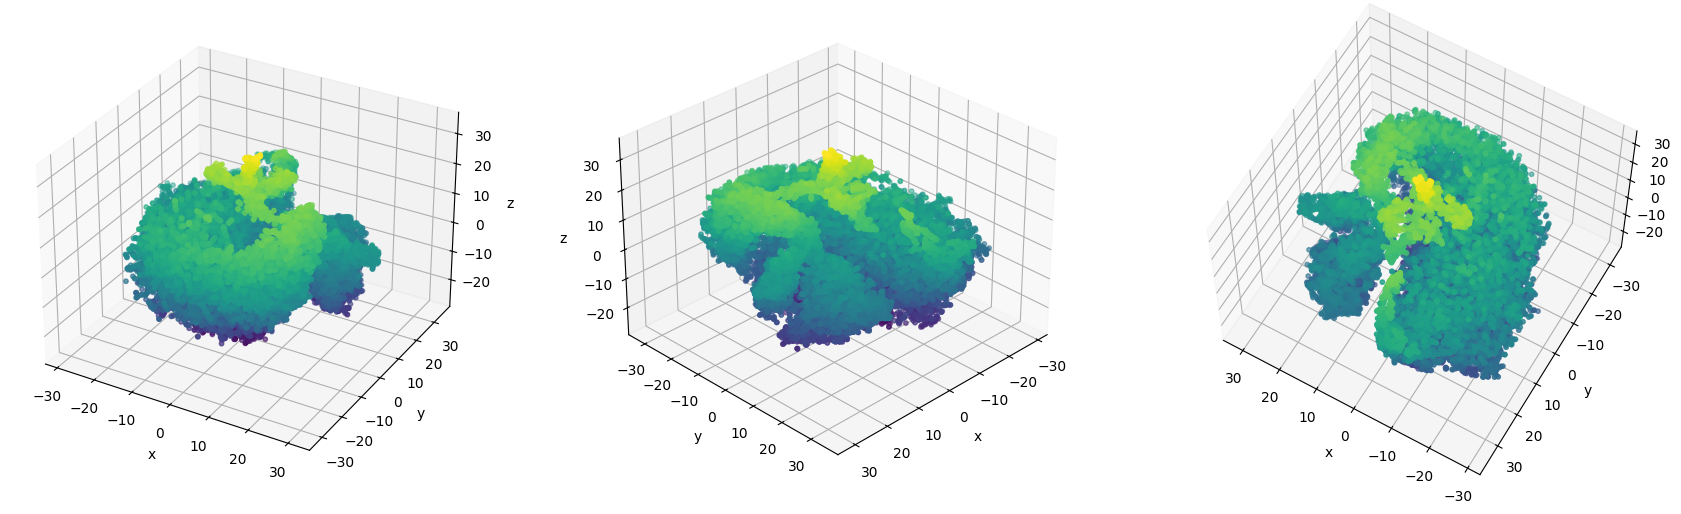

In [26]:
if os.path.exists(saved_embeddings_3d_path):
	embeddings_3d = np.load(saved_embeddings_3d_path)
else:
	tsne = TSNE(n_components=3, random_state=42)
	embeddings_3d = tsne.fit_transform(reduced_embeddings)

fig = go.Figure()

text_data = track_data['name'] + ' - ' + track_data['artist']

fig.add_trace(go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
	text=text_data,
    mode='markers',
    marker=dict(
        size=5,
        color=embeddings_3d[:, 2],
        colorscale='Viridis',
        opacity=1
    )
))

fig.update_layout(
    scene=dict(
        xaxis=dict(title='x'),
        yaxis=dict(title='y'),
        zaxis=dict(title='z')
    ),
	width=1000,
    height=800
)

fig.show()



In [18]:
np.save('misc/lyrics_embeddings_3d.npy', embeddings_3d)

In [19]:
random_song_index = np.random.randint(0, len(lyrics_embeddings_array))

random_embedding = lyrics_embeddings_array[random_song_index].reshape(1, -1)
similarities = cosine_similarity(random_embedding, lyrics_embeddings_array)

sorted_indices = np.argsort(similarities[0])[::-1]
num_similar_songs = 20
most_similar_indices = sorted_indices[:num_similar_songs].tolist()

most_similar_songs = track_data.iloc[most_similar_indices][['name', 'artist', 'year', 'loudness', 'danceability', 'liveness', 'tags']]
most_similar_songs['similarity'] = similarities[0][most_similar_indices]
most_similar_songs


,name,artist,year,loudness,danceability,liveness,tags,similarity
9076,The Unbreakable,Have Heart,2006,-2.172,0.366,0.3480,hardcore,1.000000
7202,Synagoga Satanae,Celtic Frost,2006,-3.256,0.153,0.2490,"black_metal, thrash_metal, doom_metal, avant_g...",0.992327
11050,The Unwinding Cable Car,Anberlin,2012,-8.990,0.586,0.0807,"rock, alternative_rock, acoustic, emo, love, m...",0.991770
6747,The Universe!,Do Make Say Think,2007,-5.627,0.110,0.8120,"instrumental, post_rock",0.991070
12890,Helen of Troy,Telefon Tel Aviv,2009,-5.426,0.538,0.2750,"electronic, new_wave, synthpop, idm",0.990869
12646,Wordy Rappinghood,Tom Tom Club,1981,-14.764,0.850,0.4540,"80s, funk, new_wave",0.990740
268,Alright,Supergrass,2010,-4.077,0.452,0.2990,"rock, alternative, indie, pop, alternative_roc...",0.990699
6992,Verrat,Equilibrium,2008,-3.714,0.231,0.6460,"metal, black_metal, german",0.990552
20225,In Avernus,Nothingface,2003,-3.328,0.519,0.1290,"rock, hard_rock, nu_metal",0.990493
15539,William's Tale,Manowar,1982,-15.684,0.470,0.0746,"instrumental, heavy_metal, power_metal",0.990360
